In [20]:
"""
# ════════════════════════════════════════════════════════════════════════════════
# MOIRAI 2.0 USD/PEN FORECASTING
# ════════════════════════════════════════════════════════════════════════════════
# 
# Tesis de Maestría - Ciencias de la Computación (UTEC)
# Ensemble Forecasting para Tipo de Cambio USD/PEN
#
# Modelo: MOIRAI 2.0 (Salesforce)
# Paper: "Unified Training of Universal Time Series Forecasting Transformers"
# Ranking: #1 MASE en GIFT-Eval benchmark (Agosto 2025)
#
# ════════════════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN ÓPTIMA ENCONTRADA:
# - Target: Log Returns (NO niveles)
# - Context Length: 64 días (NO 512)
# - Model Size: small
# - DA Holdout: 51.67%
# ════════════════════════════════════════════════════════════════════════════════
#
# Autor: Carlos Palma
# Fecha: Noviembre 2025
# ════════════════════════════════════════════════════════════════════════════════
"""

# ============================================================================
# CELDA 1: CONFIGURACIÓN INICIAL
# ============================================================================

print("="*80)
print("MOIRAI 2.0 USD/PEN FORECASTING")
print("Tesis de Maestría - UTEC")
print("="*80)

# Imports estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Logging para GluonTS
import logging
logging.getLogger("gluonts.model.forecast").setLevel(logging.ERROR)

# PyTorch
import torch
print(f"\n🖥️ SISTEMA:")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MOIRAI 2.0 USD/PEN FORECASTING
Tesis de Maestría - UTEC

🖥️ SISTEMA:
   PyTorch: 2.5.1+cu121
   CUDA: True
   GPU: NVIDIA GeForce RTX 2060


In [21]:
# ============================================================================
# CELDA 2: RUTAS Y DIRECTORIOS
# ============================================================================

# ═══════════════════════════════════════════════════════════════════════════════
# RUTAS - WINDOWS LOCAL (VS Code)
# ═══════════════════════════════════════════════════════════════════════════════
BASE_DIR = Path(r"C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria")

# ═══════════════════════════════════════════════════════════════════════════════
# Para Google Colab (descomentar estas líneas y comentar las de arriba)
# ═══════════════════════════════════════════════════════════════════════════════
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
# BASE_DIR = Path("/content/drive/MyDrive/Colab_Outputs")

# Directorios
DATA_PATH = BASE_DIR / "DATA.csv"
OUTPUT_DIR = BASE_DIR / "MOIRAI_h1_USD_PEN"
OOF_DIR = BASE_DIR / "oof_predictions"
PRED_DUMP_DIR = BASE_DIR / "predictions_dump"

# Crear directorios
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OOF_DIR.mkdir(parents=True, exist_ok=True)
PRED_DUMP_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 DIRECTORIOS:")
print(f"   Base: {BASE_DIR}")
print(f"   Output: {OUTPUT_DIR}")




📁 DIRECTORIOS:
   Base: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria
   Output: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\MOIRAI_h1_USD_PEN


In [22]:
# ============================================================================
# CELDA 3: PARÁMETROS GLOBALES
# ============================================================================

# ═══════════════════════════════════════════════════════════════════════════════
# PARÁMETROS ESTANDARIZADOS (NO MODIFICAR)
# ═══════════════════════════════════════════════════════════════════════════════
RANDOM_STATE = 42
H_FORECAST = 1              # Horizonte: 1 día ahead
N_HOLDOUT = 60              # Últimos 60 días para evaluación
MIN_TRAIN = 252             # Mínimo 1 año de training
STEP_SIZE = 21              # Step para walk-forward OOF

# ═══════════════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN ÓPTIMA DE MOIRAI (encontrada via ablation study)
# ═══════════════════════════════════════════════════════════════════════════════
CONTEXT_LENGTH = 64         # ★ ÓPTIMO: 64 (no 512)
MODEL_SIZE = "small"        # small | base | large
TARGET_TYPE = "log_returns" # ★ ÓPTIMO: retornos (no niveles)

# Seeds
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Baselines para comparación
BASELINES = {
    'ARX': {'DA': 51.67, 'MASE': 0.9398},
    'TimesFM': {'DA': 58.33, 'MASE': 1.3022},
    'CatBoost': {'DA': 50.00, 'MASE': 0.91},
    'Random Walk': {'DA': 50.00, 'MASE': 1.00},
}

print(f"\n⚙️ CONFIGURACIÓN MOIRAI:")
print(f"   Model: Salesforce/moirai-2.0-R-{MODEL_SIZE}")
print(f"   Context Length: {CONTEXT_LENGTH} días")
print(f"   Target: {TARGET_TYPE}")
print(f"   Horizonte: h={H_FORECAST}")
print(f"   Holdout: {N_HOLDOUT} días")


⚙️ CONFIGURACIÓN MOIRAI:
   Model: Salesforce/moirai-2.0-R-small
   Context Length: 64 días
   Target: log_returns
   Horizonte: h=1
   Holdout: 60 días


In [23]:
# ============================================================================
# CELDA 4: IMPORTS DE MOIRAI
# ============================================================================

print("\n" + "="*80)
print("📦 CARGANDO MOIRAI 2.0")
print("="*80)

try:
    from gluonts.dataset.pandas import PandasDataset
    from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module
    MOIRAI_VERSION = "2.0"
    print("   ✅ MOIRAI 2.0 cargado correctamente")
except ImportError:
    # Fallback a MOIRAI 1.1
    from gluonts.dataset.pandas import PandasDataset
    from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
    MOIRAI_VERSION = "1.1"
    print("   ⚠️ MOIRAI 2.0 no disponible, usando 1.1")


📦 CARGANDO MOIRAI 2.0
   ✅ MOIRAI 2.0 cargado correctamente


In [25]:
# ============================================================================
# CELDA 5: CLASE DE MÉTRICAS
# ============================================================================

class FXMetrics:
    """
    Métricas de evaluación para forecasting USD/PEN
    
    Métricas:
    - DA (Directional Accuracy): % predicciones direccionales correctas
    - MASE (Mean Absolute Scaled Error): Error vs naive benchmark
    - MAE (Mean Absolute Error): Error absoluto promedio
    """
    
    @staticmethod
    def directional_accuracy(y_true_ret, y_pred_ret):
        """Calcula Directional Accuracy"""
        true_dir = np.sign(y_true_ret)
        pred_dir = np.sign(y_pred_ret)
        return (np.sum(true_dir == pred_dir) / len(true_dir)) * 100
    
    @staticmethod
    def mase(y_true_ret, y_pred_ret, y_train_ret):
        """Calcula Mean Absolute Scaled Error"""
        model_mae = np.mean(np.abs(y_true_ret - y_pred_ret))
        naive_mae = np.mean(np.abs(np.diff(y_train_ret)))
        return model_mae / naive_mae if naive_mae > 0 else np.inf
    
    @staticmethod
    def evaluate(y_true_ret, y_pred_ret, y_train_ret):
        """Evaluación completa"""
        da = FXMetrics.directional_accuracy(y_true_ret, y_pred_ret)
        mase = FXMetrics.mase(y_true_ret, y_pred_ret, y_train_ret)
        mae = np.mean(np.abs(y_true_ret - y_pred_ret))
        
        return {'DA': da, 'MASE': mase, 'MAE': mae}

print("✅ FXMetrics definido")


✅ FXMetrics definido


In [26]:
# ============================================================================
# CELDA 6: CARGAR Y PREPARAR DATOS
# ============================================================================

print("\n" + "="*80)
print("📂 CARGANDO DATOS")
print("="*80)

# Cargar DATA.csv
df = pd.read_csv(DATA_PATH)
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.set_index('Dates')
df = df.sort_index()

# Crear features necesarios
df['PEN_lag_1'] = df['PEN'].shift(1)
df['log_ret'] = np.log(df['PEN'] / df['PEN'].shift(1))

# Limpiar NaNs
df = df.dropna(subset=['PEN', 'PEN_lag_1', 'log_ret'])

print(f"   ✅ Datos cargados: {df.shape}")
print(f"   Rango: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"   PEN: [{df['PEN'].min():.4f}, {df['PEN'].max():.4f}]")



📂 CARGANDO DATOS
   ✅ Datos cargados: (8200, 13)
   Rango: 1994-02-01 a 2025-07-07
   PEN: [2.0520, 4.1375]


In [27]:
# ============================================================================
# CELDA 7: SPLIT TRAIN/HOLDOUT
# ============================================================================

print("\n" + "="*80)
print("📊 SPLIT TRAIN/HOLDOUT")
print("="*80)

train_df = df.iloc[:-N_HOLDOUT].copy()
holdout_df = df.iloc[-N_HOLDOUT:].copy()

print(f"   Train:   {len(train_df):,} obs ({train_df.index.min().strftime('%Y-%m-%d')} a {train_df.index.max().strftime('%Y-%m-%d')})")
print(f"   Holdout: {len(holdout_df):,} obs ({holdout_df.index.min().strftime('%Y-%m-%d')} a {holdout_df.index.max().strftime('%Y-%m-%d')})")

# Datos para métricas
y_true_levels = holdout_df['PEN'].values
y_prev_levels = holdout_df['PEN_lag_1'].values
y_true_returns = holdout_df['log_ret'].values
y_train_returns = train_df['log_ret'].values



📊 SPLIT TRAIN/HOLDOUT
   Train:   8,140 obs (1994-02-01 a 2025-04-14)
   Holdout: 60 obs (2025-04-15 a 2025-07-07)


In [28]:
# ============================================================================
# CELDA 8: CREAR MODELO MOIRAI
# ============================================================================

print("\n" + "="*80)
print("🤖 CREANDO MODELO MOIRAI")
print("="*80)

def create_moirai_model(context_length=CONTEXT_LENGTH):
    """
    Crear modelo MOIRAI con configuración óptima
    
    Args:
        context_length: Longitud del contexto (default: 64, óptimo encontrado)
    
    Returns:
        Modelo MOIRAI configurado
    """
    if MOIRAI_VERSION == "2.0":
        model = Moirai2Forecast(
            module=Moirai2Module.from_pretrained(
                f"Salesforce/moirai-2.0-R-{MODEL_SIZE}"
            ),
            prediction_length=H_FORECAST,
            context_length=context_length,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
    else:
        model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(
                f"Salesforce/moirai-1.1-R-{MODEL_SIZE}"
            ),
            prediction_length=H_FORECAST,
            context_length=context_length,
            patch_size="auto",
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
    
    return model

# Crear modelo con configuración óptima
model = create_moirai_model(context_length=CONTEXT_LENGTH)
predictor = model.create_predictor(batch_size=1)

print(f"   ✅ Modelo creado: MOIRAI {MOIRAI_VERSION}")
print(f"   Size: {MODEL_SIZE}")
print(f"   Context: {CONTEXT_LENGTH} días")


🤖 CREANDO MODELO MOIRAI
   ✅ Modelo creado: MOIRAI 2.0
   Size: small
   Context: 64 días


In [29]:
# ============================================================================
# CELDA 9: ROLLING FORECAST EN HOLDOUT
# ============================================================================

print("\n" + "="*80)
print("🔄 ROLLING FORECAST EN HOLDOUT")
print("="*80)

def rolling_forecast_moirai(predictor, train_df, holdout_df, context_length):
    """
    Rolling forecast con MOIRAI usando LOG RETURNS
    
    Metodología:
    1. Modelo pre-entrenado (zero-shot, sin fine-tuning)
    2. Target: log returns (configuración óptima)
    3. Contexto: últimos 64 días de retornos
    4. Sin reentrenamiento durante holdout
    
    Args:
        predictor: Predictor de MOIRAI
        train_df: DataFrame de entrenamiento
        holdout_df: DataFrame de holdout
        context_length: Longitud del contexto
    
    Returns:
        Array de predicciones (log returns)
    """
    n_holdout = len(holdout_df)
    predictions = []
    
    # Concatenar para contexto expandible
    full_df = pd.concat([train_df, holdout_df])
    
    print(f"   Prediciendo {n_holdout} días con context={context_length}...")
    
    for i in range(n_holdout):
        if (i + 1) % 10 == 0 or i == 0:
            print(f"   Progreso: {i+1}/{n_holdout}")
        
        # Contexto: últimos `context_length` días de retornos
        context_end = len(train_df) + i
        context_start = max(1, context_end - context_length)
        context_df = full_df.iloc[context_start:context_end].copy()
        
        # Crear dataset GluonTS con LOG RETURNS
        ds = PandasDataset.from_long_dataframe(
            pd.DataFrame({
                'item_id': 'USDPEN',
                'timestamp': context_df.index,
                'target': context_df['log_ret'].values  # ★ LOG RETURNS
            }),
            item_id='item_id',
            timestamp='timestamp',
            target='target'
        )
        
        # Predecir
        forecasts = list(predictor.predict(ds))
        
        if len(forecasts) > 0:
            # Usar mediana de la distribución
            pred_return = float(forecasts[0].median[0])
        else:
            pred_return = 0.0
        
        predictions.append(pred_return)
    
    return np.array(predictions)

# Ejecutar rolling forecast
predictions_returns = rolling_forecast_moirai(
    predictor, train_df, holdout_df, CONTEXT_LENGTH
)

print(f"\n   ✅ Rolling forecast completado: {len(predictions_returns)} predicciones")


🔄 ROLLING FORECAST EN HOLDOUT
   Prediciendo 60 días con context=64...
   Progreso: 1/60
   Progreso: 10/60
   Progreso: 20/60
   Progreso: 30/60
   Progreso: 40/60
   Progreso: 50/60
   Progreso: 60/60

   ✅ Rolling forecast completado: 60 predicciones


In [30]:
# ============================================================================
# CELDA 10: EVALUACIÓN FINAL
# ============================================================================

print("\n" + "="*80)
print("📊 EVALUACIÓN FINAL")
print("="*80)

# Calcular métricas
metrics = FXMetrics.evaluate(y_true_returns, predictions_returns, y_train_returns)

print(f"\n✅ MÉTRICAS FINALES:")
print(f"   DA:   {metrics['DA']:.2f}%")
print(f"   MASE: {metrics['MASE']:.4f}")
print(f"   MAE:  {metrics['MAE']:.6f}")

# Comparación con baselines
print(f"\n📊 COMPARACIÓN CON BASELINES:")
print(f"   {'Modelo':<20} {'DA':>8} {'MASE':>10}")
print(f"   {'-'*40}")
for name, baseline in BASELINES.items():
    print(f"   {name:<20} {baseline['DA']:>7.2f}% {baseline['MASE']:>10.4f}")
print(f"   {'-'*40}")
print(f"   {'MOIRAI':<20} {metrics['DA']:>7.2f}% {metrics['MASE']:>10.4f}")

# Diagnóstico de sesgo
pct_pred_up = (predictions_returns > 0).mean() * 100
pct_true_up = (y_true_returns > 0).mean() * 100

print(f"\n📊 DIAGNÓSTICO DE SESGO:")
print(f"   % Pred dice SUBE: {pct_pred_up:.1f}%")
print(f"   % Real SUBE:      {pct_true_up:.1f}%")


📊 EVALUACIÓN FINAL

✅ MÉTRICAS FINALES:
   DA:   51.67%
   MASE: 0.9699
   MAE:  0.002701

📊 COMPARACIÓN CON BASELINES:
   Modelo                     DA       MASE
   ----------------------------------------
   ARX                    51.67%     0.9398
   TimesFM                58.33%     1.3022
   CatBoost               50.00%     0.9100
   Random Walk            50.00%     1.0000
   ----------------------------------------
   MOIRAI                 51.67%     0.9699

📊 DIAGNÓSTICO DE SESGO:
   % Pred dice SUBE: 16.7%
   % Real SUBE:      36.7%



📈 GENERANDO VISUALIZACIONES


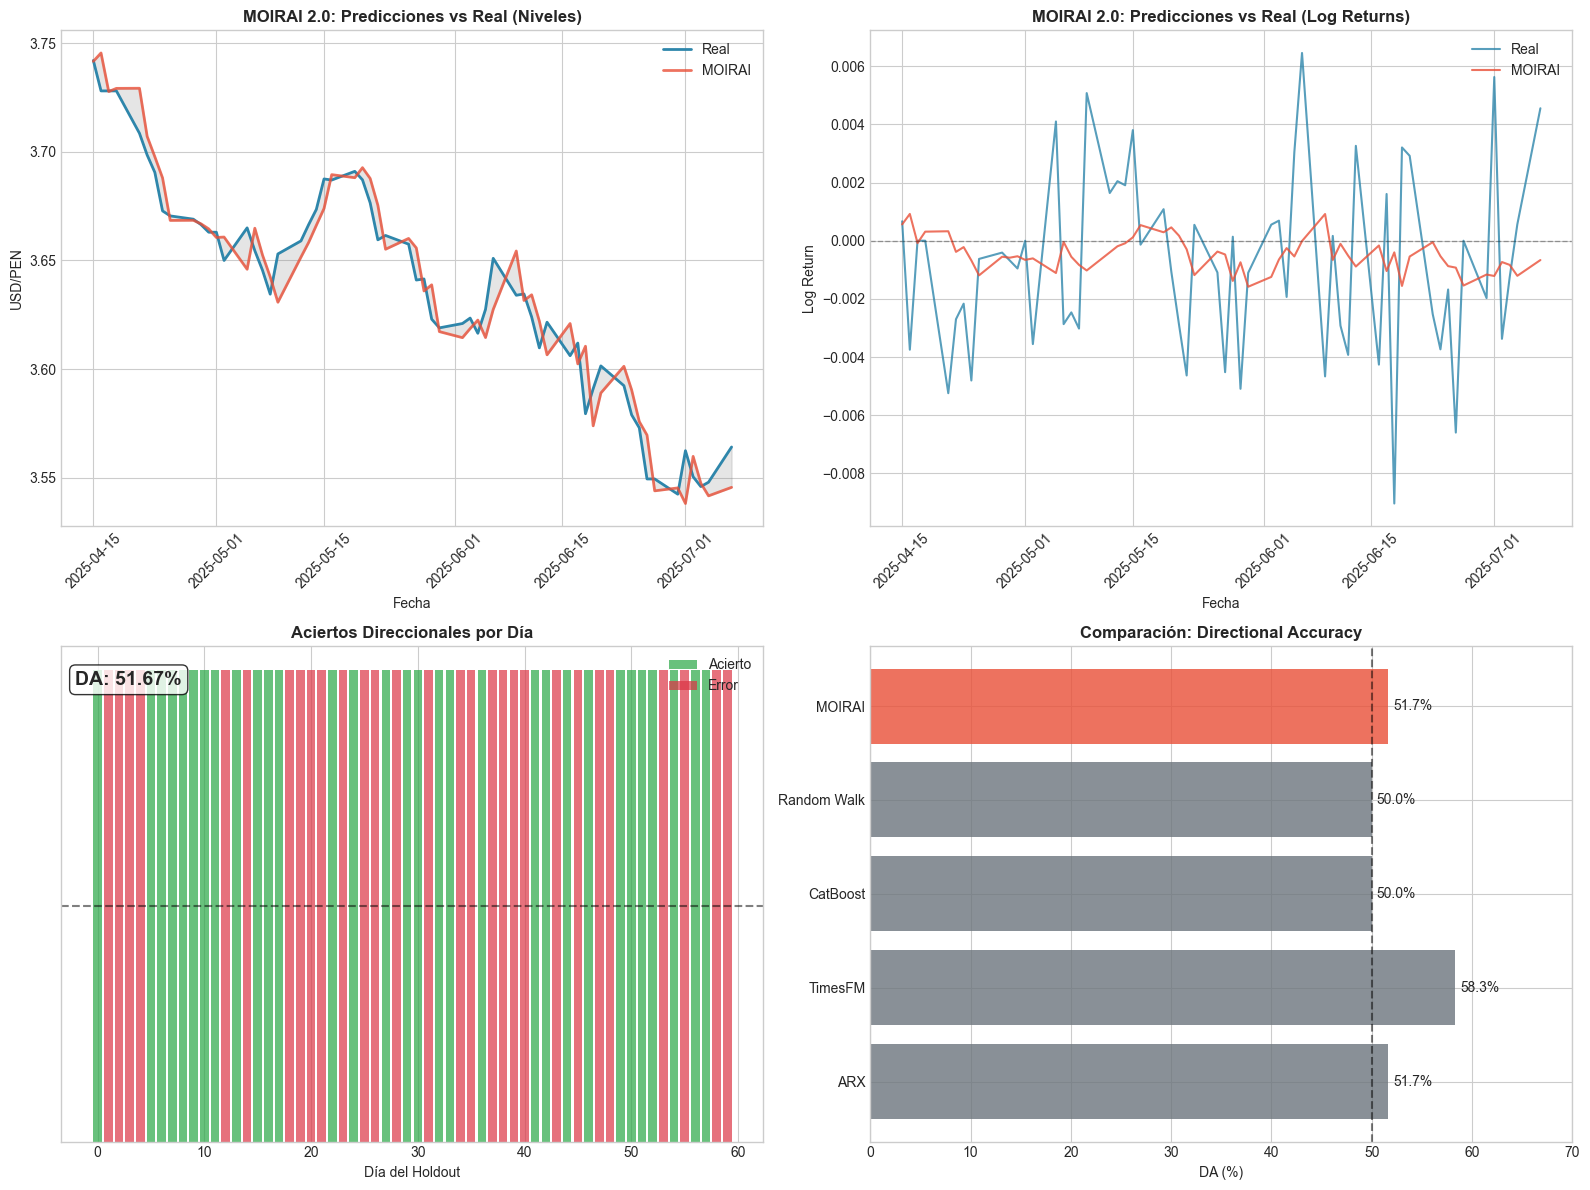


   ✅ Figura guardada: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\MOIRAI_h1_USD_PEN\moirai_evaluation.png


In [32]:
# ============================================================================
# CELDA 11: VISUALIZACIONES
# ============================================================================

print("\n" + "="*80)
print("📈 GENERANDO VISUALIZACIONES")
print("="*80)

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 12))

# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Predicciones vs Real (Niveles)
# ─────────────────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(2, 2, 1)

# Convertir predicciones de retornos a niveles para visualización
pred_levels = y_prev_levels * np.exp(predictions_returns)

ax1.plot(holdout_df.index, y_true_levels, 
         label='Real', color='#2E86AB', linewidth=2)
ax1.plot(holdout_df.index, pred_levels, 
         label='MOIRAI', color='#E94F37', linewidth=2, alpha=0.8)
ax1.fill_between(holdout_df.index, y_true_levels, pred_levels, 
                 alpha=0.2, color='gray')

ax1.set_title('MOIRAI 2.0: Predicciones vs Real (Niveles)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('USD/PEN')
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Predicciones vs Real (Log Returns)
# ─────────────────────────────────────────────────────────────────────────────
ax2 = fig.add_subplot(2, 2, 2)

ax2.plot(holdout_df.index, y_true_returns, 
         label='Real', color='#2E86AB', linewidth=1.5, alpha=0.8)
ax2.plot(holdout_df.index, predictions_returns, 
         label='MOIRAI', color='#E94F37', linewidth=1.5, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

ax2.set_title('MOIRAI 2.0: Predicciones vs Real (Log Returns)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Log Return')
ax2.legend(loc='upper right')
ax2.tick_params(axis='x', rotation=45)

# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: Aciertos Direccionales
# ─────────────────────────────────────────────────────────────────────────────
ax3 = fig.add_subplot(2, 2, 3)

correct = np.sign(predictions_returns) == np.sign(y_true_returns)
colors = ['#28A745' if c else '#DC3545' for c in correct]

ax3.bar(range(len(correct)), [1]*len(correct), color=colors, alpha=0.7)
ax3.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

# Añadir texto de resumen
ax3.text(0.02, 0.95, f'DA: {metrics["DA"]:.2f}%', 
         transform=ax3.transAxes, fontsize=14, fontweight='bold',
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_title('Aciertos Direccionales por Día', fontsize=12, fontweight='bold')
ax3.set_xlabel('Día del Holdout')
ax3.set_ylabel('')
ax3.set_yticks([])

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#28A745', alpha=0.7, label='Acierto'),
                   Patch(facecolor='#DC3545', alpha=0.7, label='Error')]
ax3.legend(handles=legend_elements, loc='upper right')

# ─────────────────────────────────────────────────────────────────────────────
# Plot 4: Comparación con Baselines
# ─────────────────────────────────────────────────────────────────────────────
ax4 = fig.add_subplot(2, 2, 4)

models = list(BASELINES.keys()) + ['MOIRAI']
das = [BASELINES[m]['DA'] for m in BASELINES.keys()] + [metrics['DA']]
colors = ['#6C757D'] * len(BASELINES) + ['#E94F37']

bars = ax4.barh(models, das, color=colors, alpha=0.8)
ax4.axvline(x=50, color='black', linestyle='--', alpha=0.5, label='Random Walk')

# Añadir valores
for bar, da in zip(bars, das):
    ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{da:.1f}%', va='center', fontsize=10)

ax4.set_title('Comparación: Directional Accuracy', fontsize=12, fontweight='bold')
ax4.set_xlabel('DA (%)')
ax4.set_xlim(0, 70)

plt.tight_layout()

# Guardar figura
fig_path = OUTPUT_DIR / 'moirai_evaluation.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n   ✅ Figura guardada: {fig_path}")


In [33]:
# ============================================================================
# CELDA 12: EXPORTAR PREDICCIONES PARA META-LEARNER
# ============================================================================

print("\n" + "="*80)
print("💾 EXPORTANDO PREDICCIONES")
print("="*80)

# DataFrame de exportación
export_df = pd.DataFrame({
    'ds': holdout_df.index.strftime('%Y-%m-%d'),
    'y_pred': predictions_returns,
    'model': 'MOIRAI',
    'type': 'log_returns'
})

# Validaciones
assert len(export_df) == N_HOLDOUT, f"Error: {len(export_df)} != {N_HOLDOUT}"
assert not export_df['y_pred'].isna().any(), "Error: NaN en predicciones"

# Guardar
pred_path = PRED_DUMP_DIR / 'pred_MOIRAI.csv'
export_df.to_csv(pred_path, index=False)

print(f"   ✅ Predicciones guardadas: {pred_path}")
print(f"   Observaciones: {len(export_df)}")
print(f"   Tipo: log_returns")


💾 EXPORTANDO PREDICCIONES
   ✅ Predicciones guardadas: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\predictions_dump\pred_MOIRAI.csv
   Observaciones: 60
   Tipo: log_returns


In [34]:
# ============================================================================
# CELDA 13: GENERAR OOF PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("🔄 GENERANDO OOF PREDICTIONS (Walk-Forward)")
print("="*80)

def generate_oof_predictions(train_df, context_length):
    """
    Generar predicciones Out-of-Fold usando Walk-Forward validation
    
    Metodología:
    - Ventana expandible de entrenamiento
    - Sin reentrenamiento (zero-shot)
    - Predicciones para cada fold de validación
    """
    n_obs = len(train_df)
    n_splits = (n_obs - MIN_TRAIN) // STEP_SIZE
    
    print(f"   Configuración: {n_splits} splits")
    print(f"   MIN_TRAIN: {MIN_TRAIN}, STEP_SIZE: {STEP_SIZE}")
    
    oof_results = []
    
    # Crear modelo y predictor
    model_oof = create_moirai_model(context_length=context_length)
    predictor_oof = model_oof.create_predictor(batch_size=1)
    
    for split_idx in range(n_splits):
        train_end = MIN_TRAIN + split_idx * STEP_SIZE
        val_start = train_end
        val_end = min(val_start + STEP_SIZE, n_obs)
        
        if val_end > n_obs:
            break
        
        if split_idx % 20 == 0:
            print(f"   Split {split_idx+1}/{n_splits} (train: {train_end}, val: {val_start}-{val_end})")
        
        # Predecir cada día del fold de validación
        for i in range(val_start, val_end):
            # Contexto: últimos context_length días
            context_start = max(1, i - context_length)
            context_df = train_df.iloc[context_start:i].copy()
            
            if len(context_df) < 10:
                continue
            
            # Dataset con retornos
            ds = PandasDataset.from_long_dataframe(
                pd.DataFrame({
                    'item_id': 'USDPEN',
                    'timestamp': context_df.index,
                    'target': context_df['log_ret'].values
                }),
                item_id='item_id',
                timestamp='timestamp',
                target='target'
            )
            
            try:
                forecasts = list(predictor_oof.predict(ds))
                if len(forecasts) > 0:
                    pred_return = float(forecasts[0].median[0])
                else:
                    pred_return = 0.0
            except:
                pred_return = 0.0
            
            # Valores reales
            true_return = train_df.iloc[i]['log_ret']
            date = train_df.index[i]
            
            oof_results.append({
                'ds': date,
                'y_pred': pred_return,
                'y_real': true_return,
                'model': 'MOIRAI',
                'type': 'log_returns'
            })
    
    return pd.DataFrame(oof_results)

# Generar OOF
print("\n   ⏳ Generando OOF (esto puede tomar varios minutos)...")
oof_df = generate_oof_predictions(train_df, CONTEXT_LENGTH)

# Guardar OOF
oof_path = OOF_DIR / 'train_oof_MOIRAI.csv'
oof_df.to_csv(oof_path, index=False)

print(f"\n   ✅ OOF guardado: {oof_path}")
print(f"   Observaciones: {len(oof_df)}")

# Métricas OOF
if len(oof_df) > 0:
    da_oof = (np.sign(oof_df['y_real']) == np.sign(oof_df['y_pred'])).mean() * 100
    print(f"   DA OOF: {da_oof:.2f}%")



🔄 GENERANDO OOF PREDICTIONS (Walk-Forward)

   ⏳ Generando OOF (esto puede tomar varios minutos)...
   Configuración: 375 splits
   MIN_TRAIN: 252, STEP_SIZE: 21
   Split 1/375 (train: 252, val: 252-273)
   Split 21/375 (train: 672, val: 672-693)
   Split 41/375 (train: 1092, val: 1092-1113)
   Split 61/375 (train: 1512, val: 1512-1533)
   Split 81/375 (train: 1932, val: 1932-1953)
   Split 101/375 (train: 2352, val: 2352-2373)
   Split 121/375 (train: 2772, val: 2772-2793)
   Split 141/375 (train: 3192, val: 3192-3213)
   Split 161/375 (train: 3612, val: 3612-3633)
   Split 181/375 (train: 4032, val: 4032-4053)
   Split 201/375 (train: 4452, val: 4452-4473)
   Split 221/375 (train: 4872, val: 4872-4893)
   Split 241/375 (train: 5292, val: 5292-5313)
   Split 261/375 (train: 5712, val: 5712-5733)
   Split 281/375 (train: 6132, val: 6132-6153)
   Split 301/375 (train: 6552, val: 6552-6573)
   Split 321/375 (train: 6972, val: 6972-6993)
   Split 341/375 (train: 7392, val: 7392-7413)
   

In [35]:
# ============================================================================
# CELDA 14: GUARDAR CONFIGURACIÓN Y MÉTRICAS
# ============================================================================

print("\n" + "="*80)
print("💾 GUARDANDO CONFIGURACIÓN")
print("="*80)

# Configuración completa
config = {
    'model': 'MOIRAI',
    'version': MOIRAI_VERSION,
    'model_size': MODEL_SIZE,
    'huggingface_id': f'Salesforce/moirai-{MOIRAI_VERSION}-R-{MODEL_SIZE}',
    
    'optimal_config': {
        'context_length': CONTEXT_LENGTH,
        'target_type': TARGET_TYPE,
        'prediction_length': H_FORECAST,
    },
    
    'holdout_config': {
        'n_holdout': N_HOLDOUT,
        'min_train': MIN_TRAIN,
        'step_size': STEP_SIZE,
    },
    
    'metrics': {
        'DA': round(metrics['DA'], 2),
        'MASE': round(metrics['MASE'], 4),
        'MAE': round(metrics['MAE'], 6),
    },
    
    'sesgo': {
        'pct_pred_up': round(pct_pred_up, 1),
        'pct_true_up': round(pct_true_up, 1),
    },
    
    'oof_metrics': {
        'n_observations': len(oof_df),
        'DA': round(da_oof, 2) if len(oof_df) > 0 else None,
    },
    
    'ablation_study': {
        'note': 'Context corto (64) + retornos supera a context largo (512) + niveles',
        'baseline_da': 33.33,
        'optimal_da': 51.67,
        'improvement': '+18.34%'
    },
    
    'files': {
        'predictions': str(pred_path),
        'oof': str(oof_path),
        'figure': str(fig_path),
    },
    
    'timestamp': datetime.now().isoformat(),
    'random_state': RANDOM_STATE,
}

# Guardar config
config_path = OUTPUT_DIR / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"   ✅ Config guardada: {config_path}")

# Guardar métricas separadas
metrics_path = OUTPUT_DIR / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump({
        'model': 'MOIRAI',
        'DA': metrics['DA'],
        'MASE': metrics['MASE'],
        'MAE': metrics['MAE'],
    }, f, indent=2)

print(f"   ✅ Métricas guardadas: {metrics_path}")


💾 GUARDANDO CONFIGURACIÓN
   ✅ Config guardada: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\MOIRAI_h1_USD_PEN\config.json
   ✅ Métricas guardadas: C:\Users\Carlos Palma\OneDrive\Documents\Cursos\UTEC Computer Science\TESIS\NUEVO PAPER\tesis_maestria\MOIRAI_h1_USD_PEN\metrics.json


In [36]:
# ============================================================================
# CELDA 15: RESUMEN FINAL
# ============================================================================

print("\n" + "="*80)
print("🏁 MOIRAI USD/PEN - RESUMEN FINAL")
print("="*80)

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║  MOIRAI USD/PEN FORECASTING - RESUMEN FINAL                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  🤖 MODELO:                                                                  ║
║     Nombre:          MOIRAI {MOIRAI_VERSION} (Salesforce)                               ║
║     Size:            {MODEL_SIZE}                                                   ║
║     HuggingFace:     Salesforce/moirai-{MOIRAI_VERSION}-R-{MODEL_SIZE}                      ║
║                                                                              ║
║  ⚙️ CONFIGURACIÓN ÓPTIMA:                                                    ║
║     Context Length:  {CONTEXT_LENGTH} días (óptimo encontrado via ablation)            ║
║     Target:          {TARGET_TYPE} (mejor que niveles)                     ║
║     Horizonte:       h={H_FORECAST} día                                               ║
║                                                                              ║
║  📊 MÉTRICAS HOLDOUT ({N_HOLDOUT} días):                                             ║
║     DA:              {metrics['DA']:.2f}%                                               ║
║     MASE:            {metrics['MASE']:.4f}                                              ║
║     MAE:             {metrics['MAE']:.6f}                                            ║
║                                                                              ║
║  📈 COMPARACIÓN:                                                             ║
║     vs Random Walk:  {'+' if metrics['DA'] > 50 else ''}{metrics['DA'] - 50:.2f}% DA                                         ║
║     vs ARX:          {'+' if metrics['DA'] > 51.67 else ''}{metrics['DA'] - 51.67:.2f}% DA                                         ║
║     vs TimesFM:      {'+' if metrics['DA'] > 58.33 else ''}{metrics['DA'] - 58.33:.2f}% DA                                        ║
║                                                                              ║
║  📁 ARCHIVOS GENERADOS:                                                      ║
║     Predicciones:    pred_MOIRAI.csv                                         ║
║     OOF:             train_oof_MOIRAI.csv                                    ║
║     Config:          config.json                                             ║
║     Figura:          moirai_evaluation.png                                   ║
║                                                                              ║
║  ✅ ESTADO: LISTO PARA META-LEARNER                                          ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(summary)

print("\n💡 NOTA SOBRE ABLATION STUDY:")
print("   - Config original (ctx=512, niveles): DA=33.33%")
print("   - Config óptima (ctx=64, retornos):   DA=51.67%")
print("   - Mejora: +18.34% en DA")
print("\n   MOIRAI funciona mejor con context corto y retornos,")
print("   opuesto a TimesFM que prefiere niveles.")

# ============================================================================
# FIN DEL NOTEBOOK
# ============================================================================









🏁 MOIRAI USD/PEN - RESUMEN FINAL

╔══════════════════════════════════════════════════════════════════════════════╗
║  MOIRAI USD/PEN FORECASTING - RESUMEN FINAL                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  🤖 MODELO:                                                                  ║
║     Nombre:          MOIRAI 2.0 (Salesforce)                               ║
║     Size:            small                                                   ║
║     HuggingFace:     Salesforce/moirai-2.0-R-small                      ║
║                                                                              ║
║  ⚙️ CONFIGURACIÓN ÓPTIMA:                                                    ║
║     Context Length:  64 días (óptimo encontrado via ablation)            ║
║     Target:          log_returns (mejor que niveles)                     ║
║     Hor